<a href="https://colab.research.google.com/github/Ariqueeezz/Personal_Data_Science_Projects/blob/main/ML_BankTransaction/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Libraries***

In [68]:
# Data Manipulation
import pandas as pd
import numpy as np
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
# Classification
from sklearn.model_selection import train_test_split, LearningCurveDisplay, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score, roc_auc_score, roc_curve
# Save Model
import joblib

In [42]:
!pip install xgboost

In [44]:
from xgboost import XGBClassifier

# ***Load Data***

In [3]:
url='https://drive.google.com/uc?id=1gnLO9qvEPqv1uBt1928AcsCmdvzqjC5m'
df = pd.read_csv(url)
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70.0,Doctor,81.0,1.0,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68.0,Doctor,141.0,1.0,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19.0,Student,56.0,1.0,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26.0,Student,25.0,1.0,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,NaN,Student,198.0,1.0,7429.40,2024-11-04 08:06:39


# ***Data Cleaning & Transformation***



In [4]:
df = df.drop(columns=['PreviousTransactionDate'])
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')

In [5]:
df.isnull().sum()

,0
TransactionID,29
AccountID,21
TransactionAmount,26
TransactionDate,28
TransactionType,30
Location,30
DeviceID,30
IP Address,20
MerchantID,23
Channel,27


In [7]:
# Mengahpus Kolom yang tidak Akan Dipakai untuk Clustering
df = df.dropna(subset=['TransactionID', 'AccountID', 'TransactionDate'])

# Imputasi Fitur Numerik
num_cols = df.select_dtypes(include=['number']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Imputasi Fitur Kategorikal
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df.isnull().sum()

,0
TransactionID,0
AccountID,0
TransactionAmount,0
TransactionDate,0
TransactionType,0
Location,0
DeviceID,0
IP Address,0
MerchantID,0
Channel,0


# ***Feature Engineering***

Fitur Baru:
1. **HourOfDay**: Untuk mendeteksi Waktu Nasabah dalam Bertransaksi. (Ekstrak Jam pada TransactionDate)
2. **AmountToBalanceRatio**: Rasio tiap Penarikan (TransactionAmount / AccountBalance)
3. **DeviceTransactionCount**: Frekuensi Transaksi di tiap Devica

In [8]:
df['HourOfDay'] = df['TransactionDate'].dt.hour
df['AmountToBalanceRatio'] = df['TransactionAmount'] / df['AccountBalance']
device_counts = df['DeviceID'].value_counts()
df['DeviceTransactionCount'] = df['DeviceID'].map(device_counts)

df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,HourOfDay,AmountToBalanceRatio,DeviceTransactionCount
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70.0,Doctor,81.0,1.0,5112.21,16,0.002756,6
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68.0,Doctor,141.0,1.0,13758.91,16,0.027345,5
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19.0,Student,56.0,1.0,1122.35,18,0.112523,5
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26.0,Student,25.0,1.0,8569.06,16,0.021531,5
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,45.0,Student,198.0,1.0,7429.40,17,0.001810,3


In [12]:
df[['HourOfDay', 'AmountToBalanceRatio', 'DeviceTransactionCount']].describe()

,HourOfDay,AmountToBalanceRatio,DeviceTransactionCount
count,2461.000000,2461.000000,2461.000000
mean,16.625762,0.199030,4.978870
std,0.732611,0.515241,4.663947
min,16.000000,0.000045,1.000000
25%,16.000000,0.018209,3.000000
50%,16.000000,0.051297,4.000000
75%,17.000000,0.146318,6.000000
max,18.000000,7.895988,39.000000


In [14]:
# Features to use
features_to_use = [
    'TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance',
    'CustomerAge', 'AmountToBalanceRatio', 'DeviceTransactionCount',
    'Location', 'TransactionType'
]

df_model = df[features_to_use].copy()

In [15]:
df_model['Location'].nunique()

43

In [17]:
location_freq = df_model['Location'].value_counts(normalize=True)
df_model['Location_Freq'] = df_model['Location'].map(location_freq)


df_model = pd.get_dummies(df_model, columns=['TransactionType'], drop_first=True)
df_model = df_model.drop(columns=['Location'])

In [19]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model)
df_scaled = pd.DataFrame(scaled_features, columns=df_model.columns)
df_scaled.head()

,TransactionAmount,TransactionDuration,LoginAttempts,AccountBalance,CustomerAge,AmountToBalanceRatio,DeviceTransactionCount,Location_Freq,TransactionType_Debit
0,-0.975280,-0.551915,-0.204981,-0.000020,1.430725,-0.381013,0.218986,-0.167503,0.533964
1,0.279459,0.307799,-0.204981,2.226598,1.318009,-0.333280,0.004531,0.401344,0.533964
2,-0.586541,-0.910129,-0.204981,-1.027451,-1.443526,-0.167931,0.004531,-0.072695,0.533964
3,-0.384861,-1.354314,-0.204981,0.890156,-1.049021,-0.344567,0.004531,-0.262310,0.533964
4,-0.977497,1.124527,-0.204981,0.596681,0.021778,-0.382849,-0.424377,-0.072695,-1.872786


# ***Clustering***

/usr/local/lib/python3.12/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.12/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


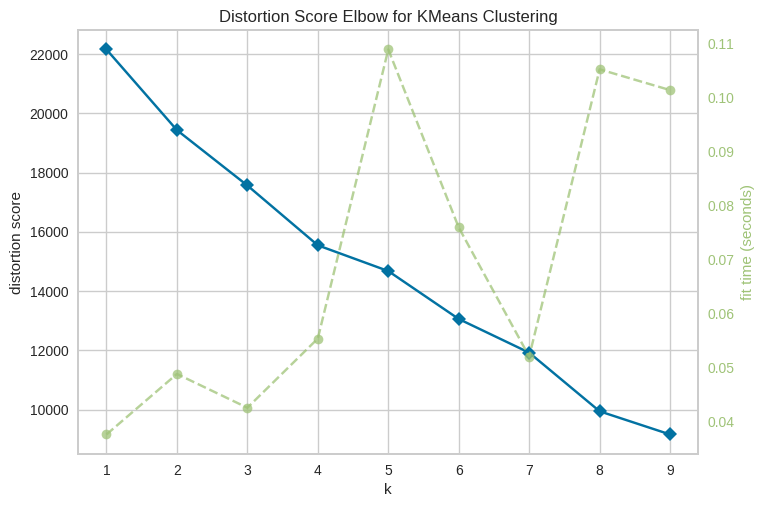

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(df_scaled)
visualizer.show()

In [73]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

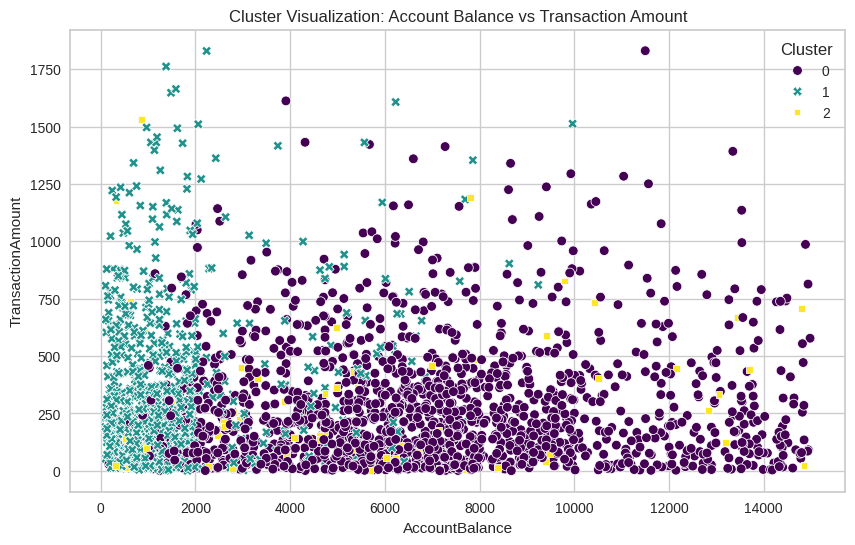

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='AccountBalance', y='TransactionAmount', hue='Cluster', palette='viridis', style='Cluster')
plt.title('Cluster Visualization: Account Balance vs Transaction Amount')
plt.show()

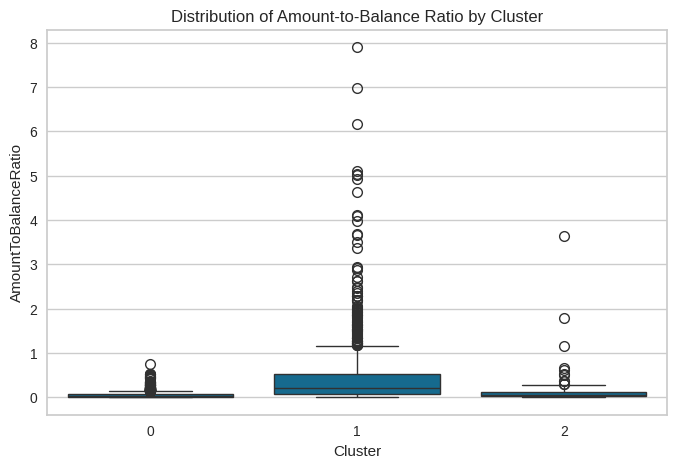

In [75]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cluster', y='AmountToBalanceRatio', data=df)
plt.title('Distribution of Amount-to-Balance Ratio by Cluster')
plt.show()

In [76]:
df.groupby('Cluster')[['TransactionAmount', 'AccountBalance', 'AmountToBalanceRatio', 'LoginAttempts', 'DeviceTransactionCount', 'CustomerAge']].mean()

,TransactionAmount,AccountBalance,AmountToBalanceRatio,LoginAttempts,DeviceTransactionCount,CustomerAge
Cluster,,,,,,
0,269.714464,6942.228209,0.053638,1.012133,4.759259,53.519796
1,348.010995,1540.261306,0.485659,1.009950,5.371891,27.308458
2,277.480989,5180.626593,0.168632,4.010989,5.285714,44.241758


In [77]:
df['Cluster'].value_counts().sort_index()

,count
Cluster,
0,1566
1,804
2,91


## **Interpretasi Cluster**

1. **Cluster 0** (Nasabah Normal / Aman)
    - **Account Balance**: Tinggi (~\$6942)
    - **Transaction Amount**: Normal (~\$269)
    - **Rasio Penarikan**: Hanya 5%
    - **Login Attempts**: Normal (Rata rata 1 kali)
    - **Customer Age**: Rata-rata 53 Tahun
    
    Analisis: Nasabah pada Cluster ini memiliki perilaku transaksi yang normal. Tidak ada hal yang mencurigakan dari Perilaku Transaksi nya.
    
2. **Cluster 0** (Nasabah Muda Normal / Berisiko)
    - **Account Balance**: Saldo Rendah (~\$1540)
    - **Transaction Amount**: Tinggi (~\$348)
    - **Rasio Penarikan**: Rata-rata ***48%***
    - **Login Attempts**: Normal (Rata rata 1 kali)
    - **Customer Age**: Rata-rata 27 Tahun
    
    Analisis: Nasabah pada Cluster ini tergolong masih muda dan FOMO, karena mmeiliki Saldo Rendah dan Rasio Penarikan 48%. Dari Rasio Penarikan bisa dibilang mencurigakan dan banyak kemungkinan yang terjadi pada Nasabah Cluster ini, bisa jadi mereka masih single jadi bebas mau beli apapun karena belum ada tanggungan, bisa jadi mereka merantau bekerja yang memiliki gaji pas-pas an jadi sekali tarik selalu banyak, dan banyak kemungkinan lainnya. Dari Perilaku Finansial, cukup mencurigakan.

3. **Cluster 0** (Nasabah Normal Tapi Mencurigakan / Bahaya)
    - **Account Balance**: Tinggi (~\$5180)
    - **Transaction Amount**: Normal (~\$277)
    - **Rasio Penarikan**: Rata-rata 16%
    - **Login Attempts**: *Mencurigakan (Rata rata 4 kali)*
    - **Customer Age**: Rata-rata 44 Tahun
    
    Analisis: Nasabah pada Cluster ini memiliki perilaku transaksi yang sangat mencurigakan, karena memiliki rata-rata Nasabah pada cluster ini Mencoba Login sebanyak 4 Kali. Namun, dari sisi Perilaku Finansial sama seperti Nasabah pada umumnya (Normal), makanya nasabah ini tidak terdeteksi karena tertutup oleh perilaku nasabah normal lainnya.


In [78]:
target_mapping = {
    0 : 0, # Normal
    1 : 0, # Normal
    2: 1 # Fraud
}
df['Cluster'] = df['Cluster'].map(target_mapping)

In [69]:
df_model.shape

(2461, 9)

In [70]:
df.shape

(2461, 19)

# **Classification**

In [84]:
X = df_model
y = df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Fold 1: 1.0000
Fold 2: 1.0000
Fold 3: 1.0000
Fold 4: 1.0000
Fold 5: 1.0000
Mean Cross-Validation Score: 1.0000


Classifier: Random Forest
Accuracy: 1.00
Recall: 1.00
F1 Score: 1.00
Precision: 1.00
ROC AUC: 1.00




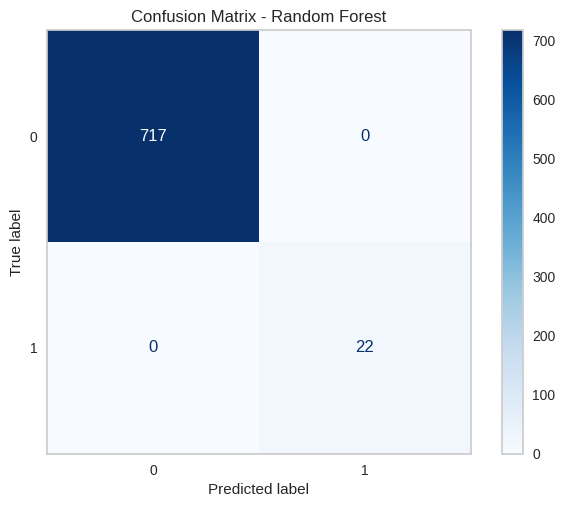

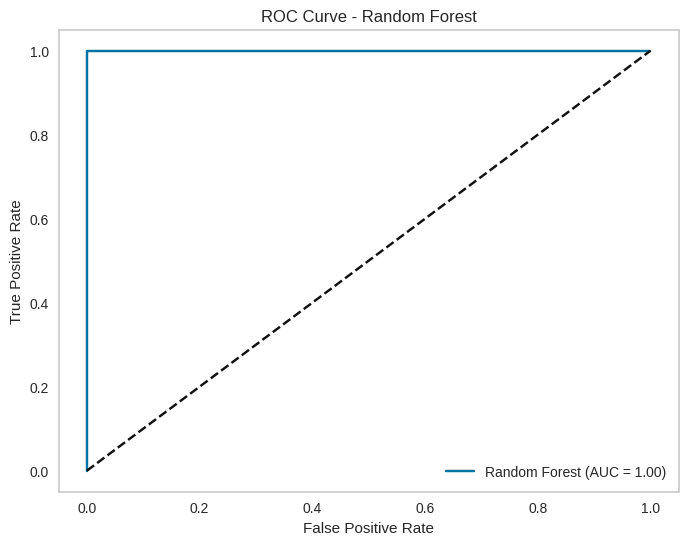

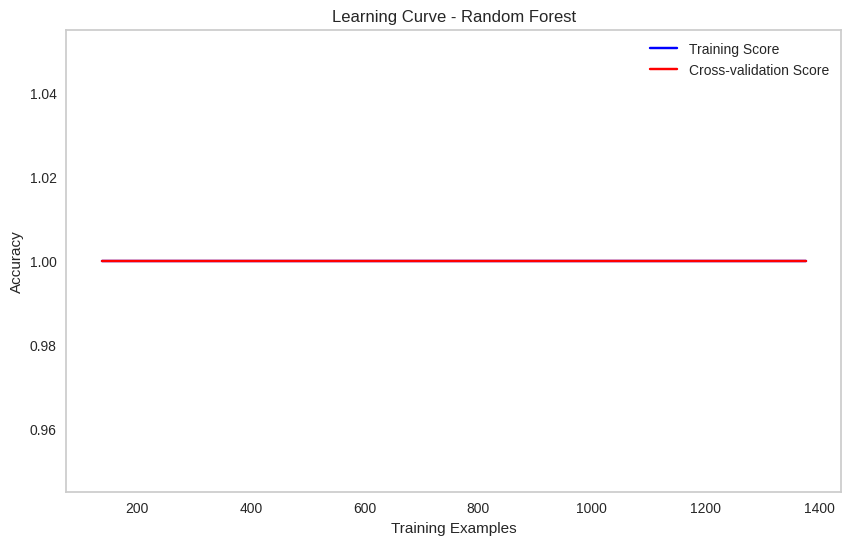

Fold 1: 1.0000
Fold 2: 1.0000
Fold 3: 1.0000
Fold 4: 1.0000
Fold 5: 1.0000
Mean Cross-Validation Score: 1.0000


Classifier: XGBoost
Accuracy: 1.00
Recall: 1.00
F1 Score: 1.00
Precision: 1.00
ROC AUC: 1.00




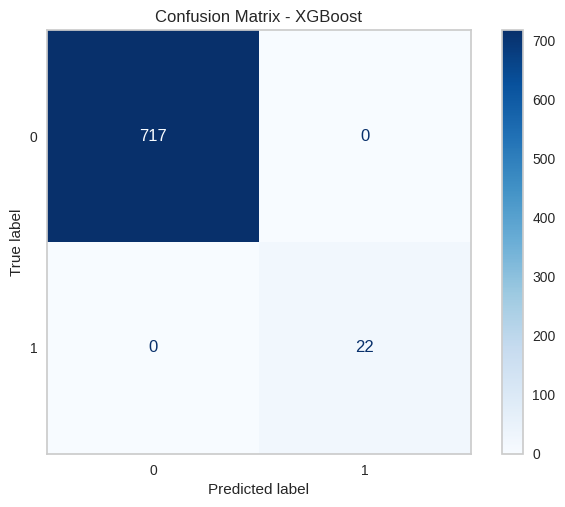

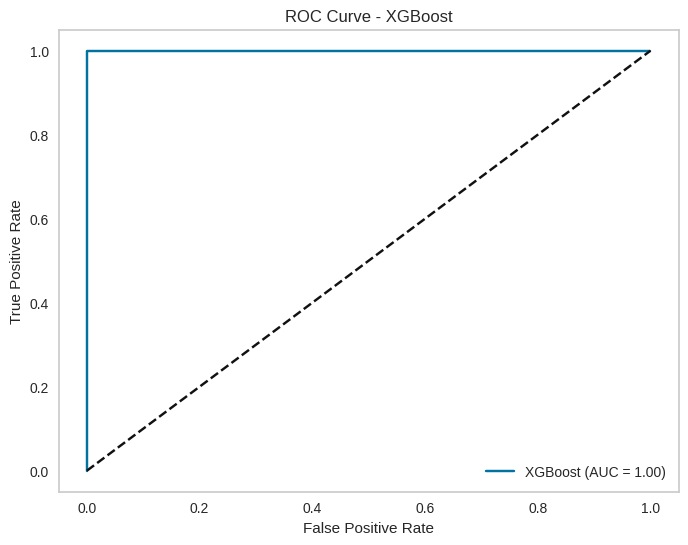

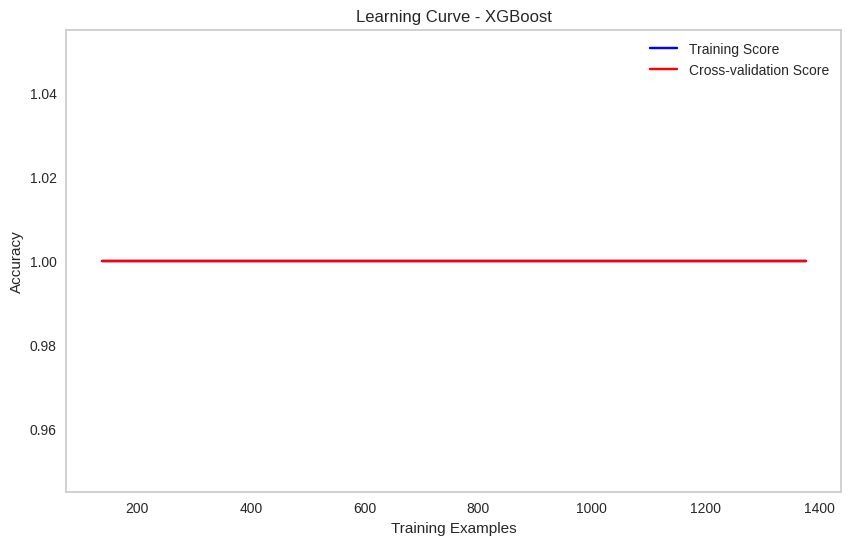

In [87]:
rfc = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, n_estimators=100)

model ={
    'Random Forest': rfc,
    'XGBoost': xgb
}


for name, classifier in model.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Cross Validation
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)
    for fold, score in enumerate(cv_scores, start=1):
        print(f"Fold {fold}: {score:.4f}")
    print(f"Mean Cross-Validation Score: {cv_scores.mean():.4f}")
    print("\n")

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("\n")

    # Confusion Matrix
    cm = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, cmap='Blues')
    cm.ax_.set_title(f"Confusion Matrix - {name}")
    plt.grid(False)
    plt.show()

    # ROC-AUC SCORE
    y_prob = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.grid(False)
    plt.show()

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation Score', color='red')
    plt.title(f'Learning Curve - {name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.show()

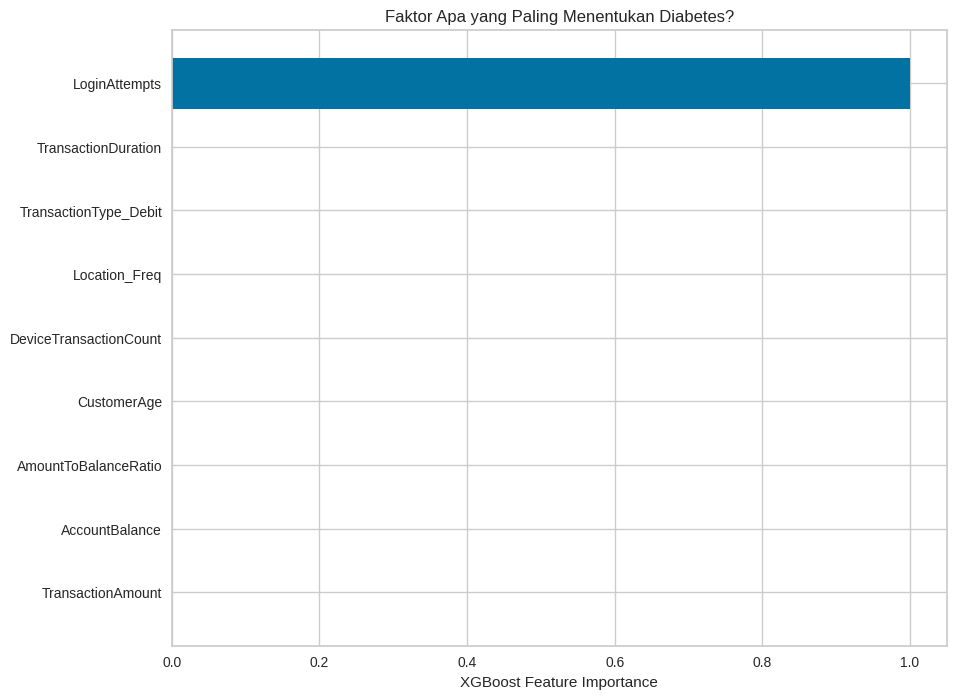

In [89]:
# Fitur penting yang dapat mempengaruhi Hasil Prediksi
feature_names = X.columns

sorted_idx = xgb.feature_importances_.argsort()
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("Faktor Apa yang Paling Menentukan Diabetes?")
plt.show()

## **Model Testing**

In [90]:
joblib.dump(xgb, 'fraud_model.joblib')

['fraud_model.joblib']

In [118]:
fraud_model = joblib.load('/content/fraud_model.joblib')

data_baru = X_test.iloc[[48]]
label_baru = y_test.iloc[48]

prediksi_baru = fraud_model.predict(data_baru)
prediksi_lama = xgb.predict(data_baru)

print(f"Data Nasabah:\n{data_baru}")
print("="*50)
print(f"Label Asli\t: {"Fraud" if label_baru == 1 else "Normal"}")
print(f"Label Prediksi\t: {"Fraud" if prediksi_baru == 1 else "Normal"}")
print("="*50)

try:
  assert prediksi_lama[0] == prediksi_baru[0]
  print("✅ Validasi Sukses: Model yang disimpan bekerja 100% sama dengan yang dilatih.")
except:
  print("❌ Validasi Gagal")


Data Nasabah:
     TransactionAmount  TransactionDuration  LoginAttempts  AccountBalance  \
454             611.11                282.0            4.0          919.84   

     CustomerAge  AmountToBalanceRatio  DeviceTransactionCount  Location_Freq  \
454         20.0              0.664366                       6        0.02438   

     TransactionType_Debit  
454                   True  
Label Asli	: Fraud
Label Prediksi	: Fraud
✅ Validasi Sukses: Model yang disimpan bekerja 100% sama dengan yang dilatih.
